# Representation

- Plot both Pretraining/Finetuning embedding for PCLR and see how M/F patients are represented in the embedding space

Get Representation file

In [19]:
import os
import pickle
import sys
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.manifold import TSNE
from scipy import stats

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from hnet import AppendNet
from get_representations import get_representations

In [88]:
def load_pretrained_model(pre_trained_loc="./PCLR.h5") :
    pre_trained_model = load_model(pre_trained_loc)
    
    return pre_trained_model

def do_bootstrap(pred_vals, trues, threshold=0.5, n=1000):
    auc_list = []
    apr_list = []
    acc_list = []
    f1_list = []
    
    preds = np.array(pred_vals > threshold).astype('float32')
    
    rng = np.random.RandomState(seed=1)
    for _ in range(n):
        idxs = rng.choice(len(trues), size=len(trues), replace=True)
        pred_arr= preds[idxs]
        true_arr = trues[idxs]
        pred_val_arr = pred_vals[idxs]

        auc = roc_auc_score(true_arr, pred_arr)
        apr = average_precision_score(true_arr, pred_arr)
        acc = accuracy_score(true_arr, np.concatenate(pred_arr))
        f1 = f1_score(true_arr, pred_arr)

        auc_list.append(auc)
        apr_list.append(apr)
        acc_list.append(acc)
        f1_list.append(f1)

    return np.array(auc_list), np.array(apr_list), np.array(acc_list), np.array(f1_list)

def confidence_interval(values, alpha=0.95):
    lower = np.percentile(values, (1-alpha)/2 * 100)
    upper = np.percentile(values, (alpha + (1-alpha)/2) * 100)
    return lower, upper

def plot_tsne(X, y, colormap=plt.cm.Paired):
    plt.figure(figsize=(8, 6))

    # clean the figure
    plt.clf()

    tsne = TSNE()
    X_embedded = tsne.fit_transform(X)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=colormap)

    plt.xticks(())
    plt.yticks(())
    plt.legend

    plt.show()
    
def plot_tsne_sns(X, y, colormap=plt.cm.Paired, plot_title="pcwp"):
    tsne = TSNE()
    X_embedded = tsne.fit_transform(X)
    df = pd.DataFrame()
    df["y"] = y
    df["comp-1"] = X_embedded[:, 0]
    df["comp-2"] = X_embedded[:, 1]
    df['y'] = df['y'].apply(lambda x: 'Male' if x else 'Female')

    sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="y")
    
    return

def get_ecg(df):
    ecgs = []
    for idx in df.index:
        row = df.loc[idx]
        qid = row['QuantaID']
        doc = row['Date_of_Cath']
        fname = f'/storage/shared/apollo/same-day/{qid}_{doc}.csv'
        x = pd.read_csv(fname).values[...,1:].astype(np.float32)
        x /= 1000
        x = x[:4096, :].T
        ecgs.append(x)
        
    ecgs = np.array(ecgs)
    return np.transpose(ecgs, (0,2,1))

def get_data(batch_size=64, sex_label=False):
    df_tab = pd.read_csv(os.path.join('/storage/shared/apollo/same-day/tabular_data.csv'))
    train_ids = np.load("./stores/train_ids.npy")
    val_ids = np.load("./stores/val_ids.npy")
    test_ids = np.load("./stores/test_ids.npy")

    train_ids = train_ids[len(train_ids) // 2 :]
    val_ids = val_ids[len(val_ids) // 2 :]
    test_ids = test_ids[len(test_ids) // 2 :]

    train_df = df_tab[df_tab["QuantaID"].isin(train_ids)]
    val_df = df_tab[df_tab["QuantaID"].isin(val_ids)]
    test_df = df_tab[df_tab["QuantaID"].isin(test_ids)]
    print(len(train_df), len(val_df), len(test_df))

    X_train = get_ecg(train_df)
    X_val = get_ecg(val_df)
    X_test = get_ecg(test_df)
    

    y_train = (train_df["PCWP_mean"].values >= 18).astype('float32')
    y_val = (val_df["PCWP_mean"].values >= 18).astype('float32')
    y_test = (test_df["PCWP_mean"].values >= 18).astype('float32')

    if sex_label:
        test_sex=test_df['Sex']
        return X_train, y_train, X_val, y_val, X_test, y_test, test_df, test_sex

    return X_train, y_train, X_val, y_val, X_test, y_test

def correct_pred(y, pred):
    y = list(y)
    assert len(y) == len(pred)
    
    corr = 0
    for i in range(len(y)):
        if y[i] == pred[i] and y[i] == 1:
            corr += 1
    return corr/len(y)

In [8]:
'''
Finetuning on Classification Task (best model: finetuned for 50 epochs)
'''

os.environ["CUDA_VISIBLE_DEVICES"]="2"

pre_trained_model = load_pretrained_model(pre_trained_loc='./PCLR.h5')
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)
full_model = AppendNet(latent, new_layers = [128, 1], classification=True)

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
loss_fn = tf.keras.losses.BinaryCrossentropy()

X_train, y_train, X_val, y_val, X_test, y_test, test_df, test_sex = get_data(sex_label=True)

epochs = 50
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

2442 893 923
Epoch 1/50


2023-04-03 13:52:42.079566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-03 13:52:44.535029: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-03 13:52:44.537220: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-03 13:52:44.537261: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-03 13:52:44.539123: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-03 13:52:44.539402: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


77/77 [==============================] - 15s 58ms/step - loss: 2.1240
Epoch 2/50
77/77 [==============================] - 4s 50ms/step - loss: 0.8727
Epoch 3/50
77/77 [==============================] - 4s 51ms/step - loss: 0.6903
Epoch 4/50
77/77 [==============================] - 4s 51ms/step - loss: 0.6304
Epoch 5/50
77/77 [==============================] - 4s 53ms/step - loss: 0.6133
Epoch 6/50
77/77 [==============================] - 4s 51ms/step - loss: 0.6135
Epoch 7/50
77/77 [==============================] - 4s 53ms/step - loss: 0.6124
Epoch 8/50
77/77 [==============================] - 4s 54ms/step - loss: 0.5888
Epoch 9/50
77/77 [==============================] - 4s 54ms/step - loss: 0.5871
Epoch 10/50
77/77 [==============================] - 4s 51ms/step - loss: 0.5752
Epoch 11/50
77/77 [==============================] - 4s 52ms/step - loss: 0.5880
Epoch 12/50
77/77 [==============================] - 4s 54ms/step - loss: 0.5897
Epoch 13/50
77/77 [============================

In [20]:
pclr_reprs = get_representations(X_test)

29/29 [==============================] - 1s 17ms/step


In [45]:
tsne = TSNE()
X_embedded = tsne.fit_transform(pclr_reprs)
df = pd.DataFrame()
df["y"] = test_sex
# df['y'] = df['y'].apply(lambda x: 'Male' if x else 'Female')

/storage/araghu/.conda/envs/hfnet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/storage/araghu/.conda/envs/hfnet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [48]:
df["comp-1"] = X_embedded[:, 0]
df["comp-2"] = X_embedded[:, 1]

In [43]:
df['y'] = df['y'].apply(lambda x: 'Male' if x else 'Female')

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

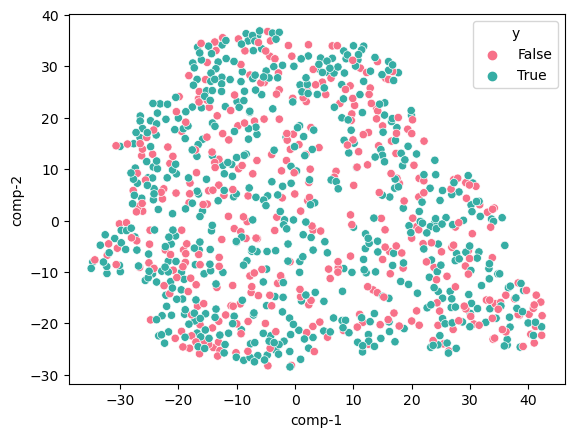

In [106]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="y", palette="husl")

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

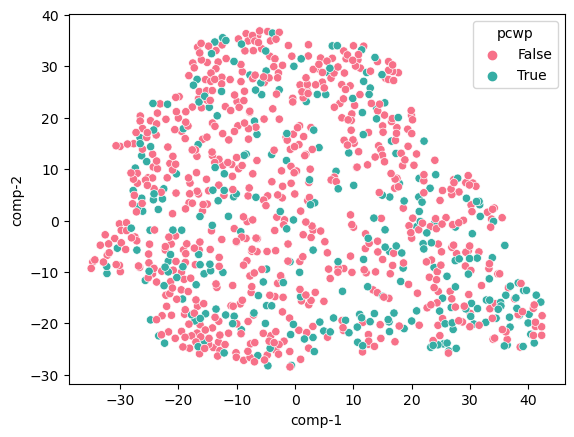

In [105]:
df["pcwp"] = test_df['PCWP_mean']>18.0
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="pcwp", palette="husl")

In [38]:
'''
Finetuning on Regression Task (best model: finetuned for 50 epochs)
'''

os.environ["CUDA_VISIBLE_DEVICES"]="2"

pre_trained_model = load_pretrained_model(pre_trained_loc='./PCLR.h5')
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)
full_model = AppendNet(latent, new_layers = [128, 1], classification=True)

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
loss_fn = tf.keras.losses.BinaryCrossentropy()

X_train, y_train, X_val, y_val, X_test, y_test, test_sex = get_data(sex_label=True)

epochs = 50
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

array([[-19.25766  ,  -5.472887 ],
       [ -7.291748 ,   9.328569 ],
       [-15.494326 ,  21.902744 ],
       ...,
       [-18.641396 ,   6.4270353],
       [-28.329594 ,   8.364059 ],
       [  5.6060057,  13.390708 ]], dtype=float32)

In [104]:
X_train, y_train, X_val, y_val, X_test, y_test, test_df, test_sex = get_data(sex_label=True)

2442 893 923


Get Label information from table_csv

In [24]:
tab = '/storage/shared/apollo/same-day/tabular_data.csv'
df_tab = pd.read_csv(tab)
df_tab = df_tab.dropna(subset=['CO'])
labels = df_tab['PCWP_mean'] > 15

In [25]:
labels

0        True
1        True
2       False
3       False
4        True
        ...  
9218    False
9219     True
9220    False
9221    False
9222    False
Name: PCWP_mean, Length: 6290, dtype: bool

# Demographic Parity

In [82]:
y_pred = full_model.predict(X_test)

auc, apr, acc, f1 = do_bootstrap(y_pred, y_test)
print(np.mean(auc), np.mean(apr), np.mean(acc), np.mean(f1))
print(confidence_interval(auc), confidence_interval(apr), confidence_interval(acc), confidence_interval(f1))

29/29 [==============================] - 1s 17ms/step
0.7516451979316785 0.5627742611972869 0.7817518959913328 0.6694311363374011
(0.7232498268503819, 0.7809334478700376) (0.5127879008261639, 0.6095188988836107) (0.7551462621885157, 0.8082340195016251) (0.6278306050059118, 0.7101007207590612)


In [85]:
male_df = test_df[test_df['Sex'] == 1]
female_df = test_df[test_df['Sex'] == 0]
male_pred = full_model.predict(get_ecg(male_df))
female_pred = full_model.predict(get_ecg(female_df))

y_male = (male_df["PCWP_mean"].values >= 18).astype('float32')
y_female = (female_df["PCWP_mean"].values >= 18).astype('float32')

print("Male")
auc, apr, acc, f1 = do_bootstrap(male_pred, y_male)
print(np.mean(auc), np.mean(apr), np.mean(acc), np.mean(f1))
print(confidence_interval(auc), confidence_interval(apr), confidence_interval(acc), confidence_interval(f1))

print("Female")
auc, apr, acc, f1 = do_bootstrap(female_pred, y_female)
print(np.mean(auc), np.mean(apr), np.mean(acc), np.mean(f1))
print(confidence_interval(auc), confidence_interval(apr), confidence_interval(acc), confidence_interval(f1))

12/12 [==============================] - 0s 16ms/step
Male
0.7602629869090378 0.5513374289855029 0.7864475138121547 0.6714114924988818
(0.7185152267344335, 0.7997700611274039) (0.48535721433267487, 0.6139725313532514) (0.7513812154696132, 0.8213627992633518) (0.6124780198776759, 0.7247261235955056)
Female
0.7423236183861787 0.5796556448814192 0.7759815789473684 0.6647492487012358
(0.69593462848891, 0.7860486393059638) (0.5086690240407814, 0.6512344449576352) (0.7315789473684211, 0.8157894736842105) (0.5984235833225765, 0.72663505559189)


In [83]:
male_df = test_df[test_df['Sex'] == True]
female_df = test_df[test_df['Sex'] == False]
male_pred = full_model.predict(get_ecg(male_df))
female_pred = full_model.predict(get_ecg(female_df))
print(len(y_pred), len(male_pred), len(female_pred))

12/12 [==============================] - 0s 17ms/step
923 543 380


In [81]:
len(X_test)

923

In [74]:
len(female_pred)

380

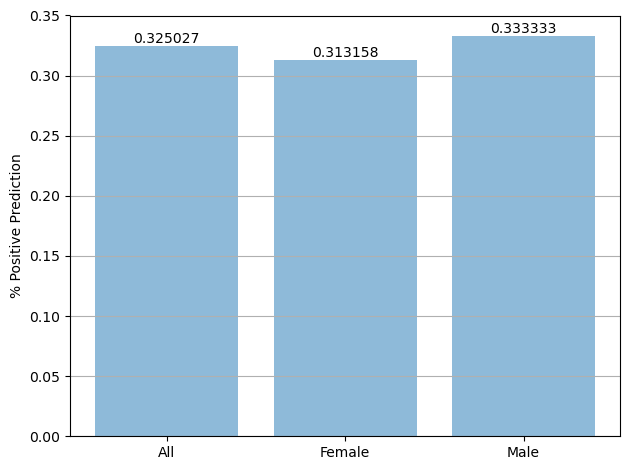

In [97]:
# Demographic Parity: Gender
threshold = 0.5
y_predict = np.array(y_pred > threshold).astype('float32')
Male_y_predict = np.array(male_pred > threshold).astype('float32')
Female_y_predict = np.array(female_pred > threshold).astype('float32')

fig, ax = plt.subplots()
x_labels = ['All', 'Female', 'Male']
x_pos = np.arange(len(x_labels))
dp = [y_predict.sum()/len(y_predict), Female_y_predict.sum()/len(Female_y_predict), Male_y_predict.sum()/len(Male_y_predict)]
ax.bar(x_pos, dp, align='center', alpha=0.5, capsize=10)
ax.set_ylabel('% Positive Prediction')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
# ax.set_ylim(0.95, 1.0)
ax.bar_label(ax.containers[0], label_type='edge')
ax.yaxis.grid(True)

# plt.savefig('./figures/lr_dp_gender.jpg')
# Show the plot
plt.tight_layout()
plt.show()

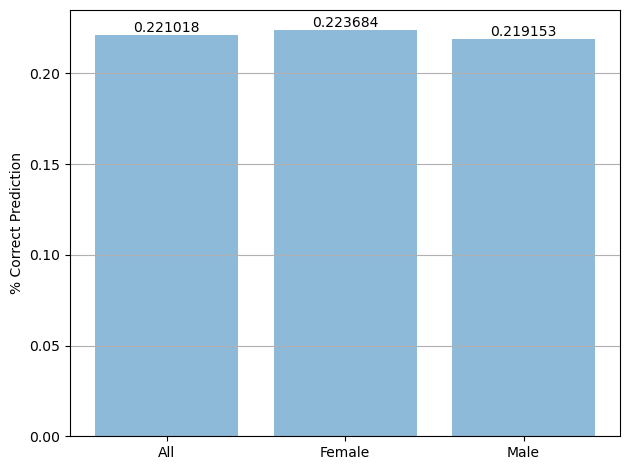

In [98]:
# Equal Opportunity Parity: Gender
fig, ax = plt.subplots()
x_labels = ['All', 'Female', 'Male']
x_pos = np.arange(len(x_labels))
ep = [correct_pred(y_test, y_predict), correct_pred(y_female, Female_y_predict), correct_pred(y_male, Male_y_predict)]
ax.bar(x_pos, ep, align='center', alpha=0.5, capsize=10)
ax.set_ylabel('% Correct Prediction')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
# ax.set_ylim(0.5, 0.9)
ax.bar_label(ax.containers[0], label_type='edge')
ax.yaxis.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [66]:
len(y_pred)

543

In [65]:
len(Female_y_predict)

543